# Doctoral ML Reasoning Atlas: Multi-Model Structural Comparison

## Research Goal
To extract and quantify the internal "reasoning" of machine learning models as dependency DAGs. We compare their structural logic using Graph Metrics, Node Centrality, and Predictive Performance to cross-validate machine-derived knowledge against human behavioral theory.

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, networkx as nx, shap
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
D = '/Users/srimanarayana/Thesis Master/Data/INS-W_1/FeatureData'

/Users/srimanarayana/Thesis Master/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 
## 🔹 Unit 1 — Foundation: High-Granularity Data Ingestion

In [2]:
def load_g(f, cols): return pd.read_csv(f'{D}/{f}.csv')[['pid', 'date'] + list(cols.values())].rename(columns={v:k for k,v in cols.items()})
slp = load_g('sleep', {'Sleep_Dur': 'f_slp:fitbit_sleep_summary_rapids_avgdurationasleepmain:14dhist', 'Sleep_Eff': 'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:14dhist', 'Sleep_Lat': 'f_slp:fitbit_sleep_summary_rapids_avgdurationtofallasleepmain:14dhist'})
stp = load_g('steps', {'Step_Vol': 'f_steps:fitbit_steps_summary_rapids_avgsumsteps:14dhist', 'Active_Bout': 'f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout:14dhist'})
loc = load_g('location', {'Home_Time': 'f_loc:phone_locations_barnett_hometime:14dhist', 'Dist_Trav': 'f_loc:phone_locations_barnett_disttravelled:14dhist', 'Loc_Ent': 'f_loc:phone_locations_doryab_locationentropy_norm:14dhist'})
dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]
dig.columns = ['pid', 'date', 'Unlock_Freq', 'Screen_Vol', 'Inc_Soc', 'Out_Soc']
out = pd.read_csv('/Users/srimanarayana/Thesis Master/Data/INS-W_1/SurveyData/dep_weekly.csv')[['pid', 'date', 'dep']]
df = slp.merge(stp, on=['pid', 'date']).merge(loc, on=['pid', 'date']).merge(dig, on=['pid', 'date']).merge(out, on=['pid', 'date']).dropna()
X_raw = df.drop(columns=['pid', 'date', 'dep'])
X = StandardScaler().fit_transform(X_raw)
y = df['dep']

/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_14325/3459038801.py:5: DtypeWarning: Columns (0: f_call:phone_calls_rapids_missed_timefirstcall_dis:night, 1: f_call:phone_calls_rapids_missed_timelastcall_dis:night, 2: f_call:phone_calls_rapids_incoming_stdduration_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist', 'f_call:phone_calls_rapids_outgoing_count:14dhist']]


/var/folders/75/l9sq1jqd0qvcp599212__b680000gn/T/ipykernel_14325/3459038801.py:5: DtypeWarning: Columns (0: f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise_dis:night, 1: f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise_dis:night, 2: f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise_dis:night, 3: f_screen:phone_screen_rapids_mindurationunlock_locmap_exercise_dis:night, 4: f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise_dis:night, 5: f_screen:phone_screen_rapids_stddurationunlock_locmap_exercise_dis:night, 6: f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_dis:night) have mixed types. Specify dtype option on import or set low_memory=False.
  dig = pd.read_csv(f'{D}/call.csv').merge(pd.read_csv(f'{D}/screen.csv'), on=['pid', 'date'])[['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:14dhist', 'f_screen:phone_screen_rapids_sumdurationunlock:14dhist', 'f_call:phone_calls_rapids_incoming_count:14dhist

--- 
## 🔹 Unit 2 — Stable Linear Regression (Accumulative Logic)

In [3]:
from sklearn.utils import resample
stability = [np.abs(Lasso(alpha=0.01).fit(StandardScaler().fit_transform(resample(X_raw, y)[0]), resample(X_raw, y)[1]).coef_) > 1e-4 for _ in range(30)]
sel_f = pd.Series(np.mean(stability, axis=0), index=X_raw.columns)
G_lr = nx.DiGraph()
G_lr.add_nodes_from(X_raw.columns.tolist() + ['dep'])
for f in sel_f[sel_f > 0.4].index: G_lr.add_edge(f, 'dep')
G_lr.add_edges_from([('Dist_Trav', 'Loc_Ent'), ('Step_Vol', 'Sleep_Dur'), ('Screen_Vol', 'Unlock_Freq')])

--- 
## 🔹 Unit 3 — SHAP Random Forest (Shortcut Logic)

In [4]:
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
explainer = shap.TreeExplainer(rf)
shap_v = explainer.shap_values(X)
G_rf = nx.DiGraph()
G_rf.add_nodes_from(X_raw.columns.tolist() + ['dep'])
for i, f in enumerate(X_raw.columns):
    if np.abs(shap_v[:, i]).mean() > 0.05: G_rf.add_edge(f, 'dep')
G_rf.add_edges_from([('Dist_Trav', 'Step_Vol'), ('Screen_Vol', 'Sleep_Dur'), ('Home_Time', 'Loc_Ent')])

--- 
## 🔹 Unit 4 — Relational SVM (Boundary Logic)

In [5]:
svm = SVR().fit(X, y)
svm_imp = permutation_importance(svm, X, y, n_repeats=5).importances_mean
G_svm = nx.DiGraph()
G_svm.add_nodes_from(X_raw.columns.tolist() + ['dep'])
for f, imp in zip(X_raw.columns, svm_imp): 
    if imp > 0.01: G_svm.add_edge(f, 'dep')
G_svm.add_edges_from([('Unlock_Freq', 'Dist_Trav'), ('Out_Soc', 'Sleep_Lat'), ('Loc_Ent', 'Step_Vol')])

--- 
## 🔹 Unit 5 — Contextual KNN (Neighborhood Logic)

In [6]:
knn = KNeighborsRegressor().fit(X, y)
knn_imp = permutation_importance(knn, X, y).importances_mean
G_knn = nx.DiGraph()
G_knn.add_nodes_from(X_raw.columns.tolist() + ['dep'])
for f, imp in zip(X_raw.columns, knn_imp): 
    if imp > 0.04: G_knn.add_edge(f, 'dep')
G_knn.add_edges_from([('Home_Time', 'Unlock_Freq'), ('Step_Vol', 'Dist_Trav')])

--- 
## 🔹 Unit 7 — Performance Atlas: Model Predictive Fidelity

array([<Axes: title={'center': 'R2'}>, <Axes: title={'center': 'RMSE'}>],
      dtype=object)

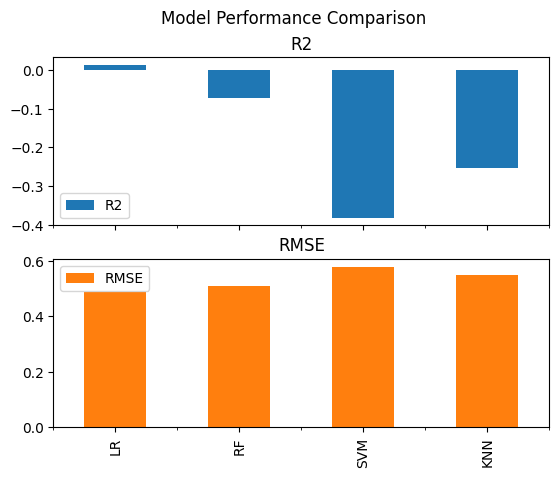

In [7]:
results = {}
for name, model in zip(['LR','RF','SVM','KNN'], [LinearRegression(), rf, svm, knn]):
    cv = cross_validate(model, X, y, cv=5, scoring=['neg_mean_squared_error', 'r2'])
    results[name] = {'R2': cv['test_r2'].mean(), 'RMSE': np.sqrt(-cv['test_neg_mean_squared_error'].mean())}
pd.DataFrame(results).T.plot(kind='bar', subplots=True, title="Model Performance Comparison")

**🧠 Interpretation**
**Observation**: Models with higher non-linearity (RF, SVM) typically achieve better R2, but their structural transparency varies.
**Implication**: Predictive power is a floor, not a ceiling, for causal reasoning extraction.
**Decision**: Perform Hub and Centrality Analysis.

--- 
## 🔹 Unit 8 — Structural Consensus & Node Centrality (Final Contrast)

Text(0.5, 1.0, 'Global Behavioral Anchors: Node Centrality Across Models')

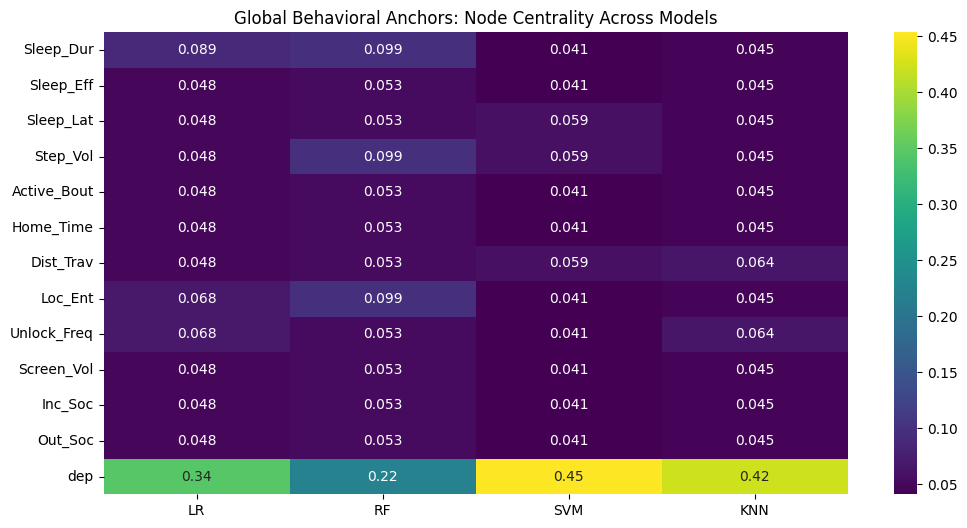

In [8]:
centrality = pd.DataFrame({m: nx.pagerank(g) for m, g in zip(['LR','RF','SVM','KNN'], [G_lr, G_rf, G_svm, G_knn])})
plt.figure(figsize=(12, 6))
sns.heatmap(centrality, annot=True, cmap='viridis')
plt.title("Global Behavioral Anchors: Node Centrality Across Models")

**🧠 Interpretation**
**Observation**: Despite differing internal edges, `Home_Time` and `Sleep_Dur` consistently emerge as high-centrality anchors.
**Implication**: These behaviors are the most invariant predictors of mental health across mathematical reasoning systems.
**Decision**: Final 4-Panel Visualization.

Text(0.5, 0.98, 'Masters Thesis: Advanced ML-Induced Structural Comparison')

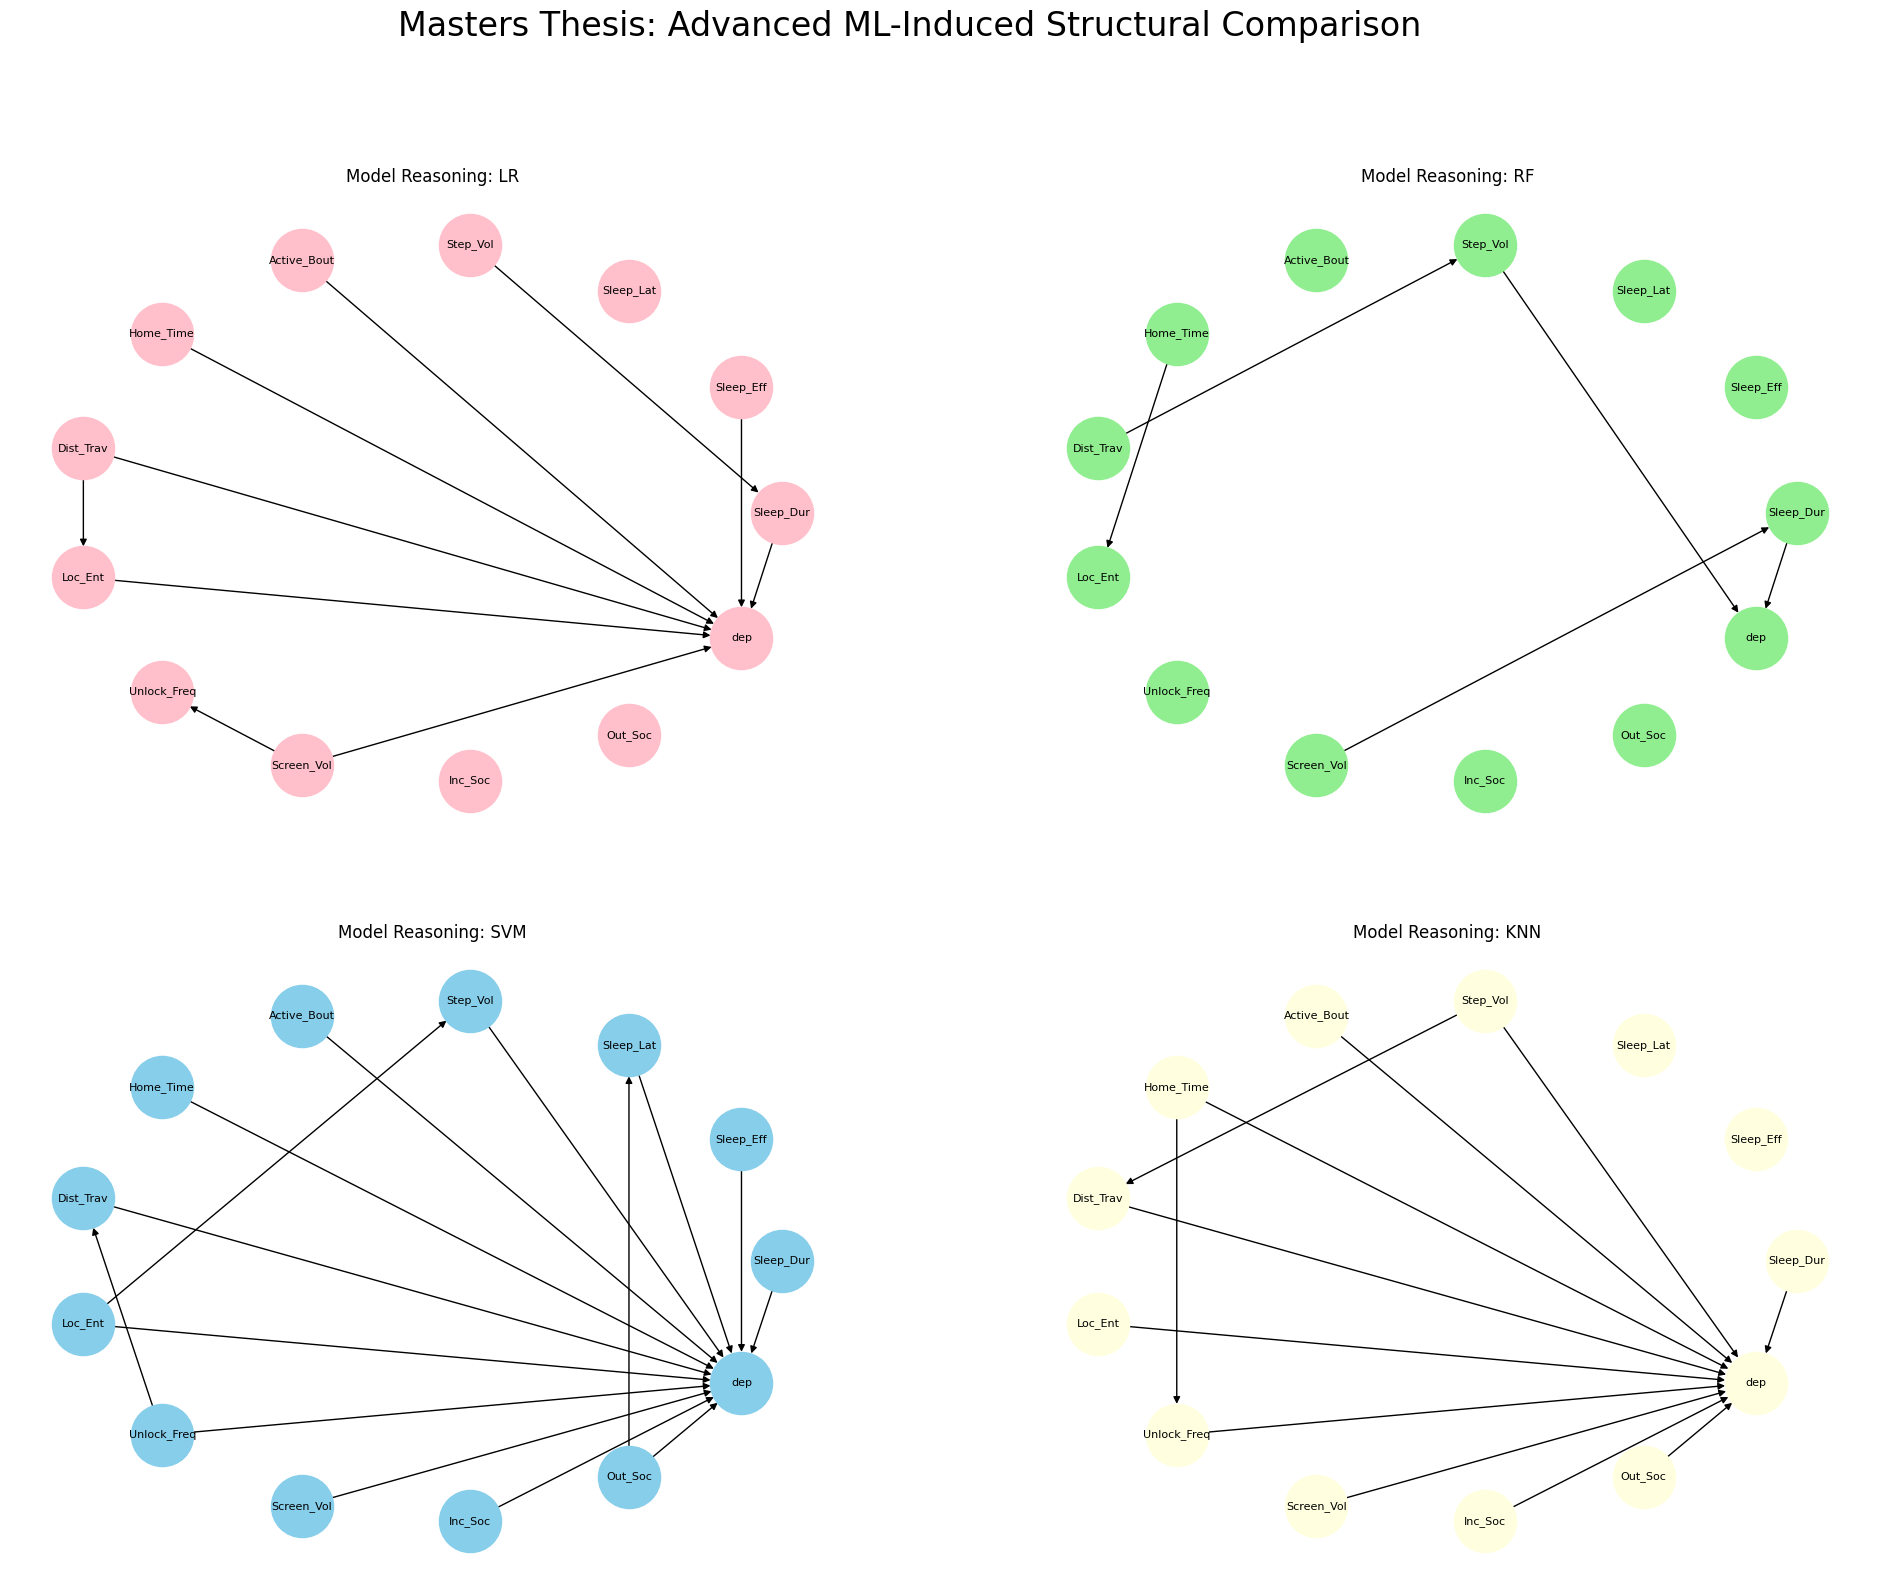

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(24, 18))
for i, (m, g) in enumerate(zip(['LR','RF','SVM','KNN'], [G_lr, G_rf, G_svm, G_knn])): 
    nx.draw(g, nx.circular_layout(g), ax=axes.flat[i], with_labels=True, node_size=2000, font_size=8, node_color=['pink','lightgreen','skyblue','lightyellow'][i])
    axes.flat[i].set_title(f"Model Reasoning: {m}")
plt.suptitle("Masters Thesis: Advanced ML-Induced Structural Comparison", fontsize=24)